In [2]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import IMREAD_GRAYSCALE
import os

In [18]:
def feature_engineering(train_path, img_name, inferrence= False):
    df = pd.DataFrame()

    img = cv2.imread(os.path.join(train_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    df['og_pixels'] = img.reshape(-1)
    df['img'] = img_name

    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    gabor_label = 'gabor_' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype= cv2.CV_32F)
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    num += 1

    edges = cv2.Canny(img, 100, 200)
    edges1 = edges.reshape(-1)
    df['canny'] = edges1

    from skimage.filters import roberts, sobel, scharr, prewitt, gaussian

    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['roberts'] = edge_roberts1

    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['sobel'] = edge_sobel1

    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['scharr'] = edge_scharr1

    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['prewitt'] = edge_prewitt1

    gaussian_img = gaussian(img, 3)
    df['gaussian_s3'] = gaussian_img.reshape(-1)

    gaussian_img2 = gaussian(img, 7)
    df['gaussian_s7'] = gaussian_img2.reshape(-1)


    median_img = cv2.medianBlur(img, 3)
    df['median_s3'] = median_img.reshape(-1)

    if inferrence:
        df = df.drop('img', axis= 1)

    return df

In [4]:
train_df = pd.DataFrame()
train_path = './sandstone_data_for_ML/train/'

In [5]:
for img_name in os.listdir(train_path):
    print(f'Loading {img_name}')
    df = feature_engineering(train_path, img_name)
    train_df = pd.concat([train_df, df])
train_df


Loading 0.jpg
Loading 7.jpg
Loading 8.jpg
Loading 2.jpg
Loading 5.jpg
Loading 6.jpg
Loading 3.jpg
Loading 1.jpg
Loading 4.jpg


,og_pixels,img,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019899,0,4.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019900,0,4.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019901,0,4.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019902,0,4.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
train_label_df = pd.DataFrame()
train_label_path = './sandstone_data_for_ML/labels/'

for label in os.listdir(train_label_path):
    df = pd.DataFrame()
    label_img = cv2.imread(os.path.join(train_label_path, label))

    label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2GRAY)

    df['label'] = label_img.reshape(-1)
    df['img_label'] = label

    train_label_df = pd.concat([train_label_df, df])
train_label_df

,label,img_label
0,0,0.jpg
1,0,0.jpg
2,0,0.jpg
3,0,0.jpg
4,0,0.jpg
...,...,...
1019899,0,4.jpg
1019900,0,4.jpg
1019901,0,4.jpg
1019902,0,4.jpg


In [7]:
data_df = pd.concat([train_df, train_label_df], axis= 1)

data_df['img'].equals(data_df['img_label'])

True

In [8]:
data_df = data_df[data_df['label'] != 0]

In [9]:
X = data_df.drop(['img', 'img_label','label'], axis= 1)
# X = data_df.drop('label', axis= 1)
Y = data_df['label'].values

In [10]:
X

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
26432,16,0,0,67,40,25,15,14,8,0,...,0,0,0,0.016867,0.014037,0.016326,0.011169,0.049637,0.043832,14
26433,17,0,0,62,43,23,16,10,6,0,...,2,0,0,0.006201,0.006932,0.008122,0.005390,0.046972,0.043565,17
26434,19,0,0,39,35,14,17,8,13,0,...,37,28,0,0.049059,0.029379,0.030638,0.027807,0.045086,0.043341,14
26435,6,0,0,14,6,0,0,0,0,0,...,34,24,0,0.008319,0.034032,0.036579,0.030726,0.044447,0.043166,7
26436,3,0,0,30,12,9,0,5,0,0,...,13,5,0,0.040942,0.020116,0.019931,0.020419,0.045172,0.043043,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915947,169,0,0,255,255,231,148,83,60,0,...,109,65,0,0.064736,0.106218,0.104079,0.109074,0.521706,0.508118,169
915948,178,0,0,255,255,255,212,198,113,0,...,107,63,0,0.052320,0.025883,0.024260,0.028475,0.522542,0.508712,169
915949,163,0,0,255,255,255,150,100,51,0,...,114,74,0,0.069822,0.067012,0.063725,0.071514,0.515412,0.509352,163
915950,159,0,0,255,255,242,144,106,64,0,...,75,47,0,0.138759,0.104824,0.101897,0.108968,0.500966,0.509975,159


In [11]:
Y

array([1, 1, 1, ..., 2, 1, 1], dtype=uint8)

In [12]:
groups = []
for i in range(0, len(data_df)):
    groups.append(int((i / 1019904) + 1))
print(len(groups))

340294


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators= 50, random_state= 42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, shuffle= False)
model.fit(X_train, Y_train)

pred = model.predict(X_test)



In [14]:
from sklearn.metrics import accuracy_score, f1_score

f1 = f1_score(Y_test, pred, average= 'macro')
acc = accuracy_score(Y_test, pred)
print(f'f1 score: {f1}')
print(f'accuracy score: {acc}')

f1 score: 0.5687089198816692
accuracy score: 0.8655137454267621


In [22]:
img_test = cv2.imread(os.path.join(train_label_path, '0.jpg'))
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
img_test_df = feature_engineering(train_path, '0.jpg', True)
img_test_df

,og_pixels,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_31,gabor_32,canny,roberts,sobel,scharr,prewitt,gaussian_s3,gaussian_s7,median_s3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1019902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


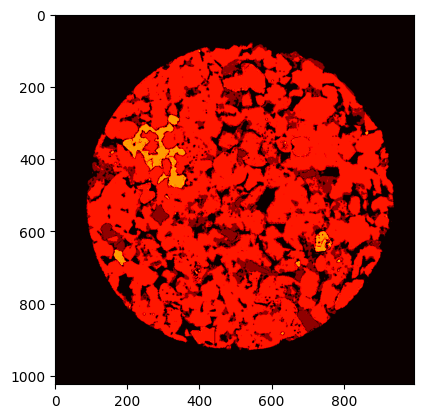

In [26]:
segmented_img_test = model.predict(img_test_df)
segmented_img_test = segmented_img_test.reshape((img_test.shape))
plt.imshow(segmented_img_test, cmap= 'hot')